# Exercise 5  - Variational quantum eigensolver  solution

**Created by:** Igor O. Sokolov

This notebook provides a concise description of the logical steps required to obtain the solution without
the theoretical details. For the latter, refer to the original `ex5` notebook that contains the links to the resources.

## Solution for Part 1 : Tutorial - VQE for H$_2$ molecule 

In this part, you will simulate H$_2$ molecule using the STO-3G basis with the PySCF driver and Jordan-Wigner mapping. 
Let's use the code from the tutorial (see the original notebook) to answer the basic questions about the molecule.

In [ ]:
# Classical HF computation

from qiskit_nature.drivers import PySCFDriver

molecule = "H .0 .0 .0; H .0 .0 0.739"
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

The driver will execute the HF calculation. Knowing that each hydrogen atom has 1 electron, we expect each H atom to have a single 1s molecular orbital and hence 2 molecular orbitals in total (considering the minimal basis set, STO-3G, that is employed by default in all the drivers unless specified otherwise).

<div class="alert alert-block alert-danger">

<b>Questions</b> 
    
Look into the attributes of `qmolecule` and answer the questions below.

    
1. We need to know the basic characteristics of our molecule. What is the total number of electrons in your system?
2. What is the number of molecular orbitals?
3. What is the number of spin-orbitals?
3. How many qubits would you need to simulate this molecule with Jordan-Wigner mapping?
5. What is the value of the nuclear repulsion energy?
    
</div>

</div>

<div class="alert alert-block alert-success">

<b>Answers </b> 

1. `n_el = qmolecule.num_alpha + qmolecule.num_beta`
    
2. `n_mo = qmolecule.num_molecular_orbitals`
    
3. `n_so = 2 * qmolecule.num_molecular_orbitals`
    
4. `n_q = n_so`
    
5. `e_nn = qmolecule.nuclear_repulsion_energy`
    
    
</div>

In [2]:
n_el = qmolecule.num_alpha + qmolecule.num_beta
n_mo = qmolecule.num_molecular_orbitals
n_so = 2 * qmolecule.num_molecular_orbitals
n_q = n_so
e_nn = qmolecule.nuclear_repulsion_energy

print("1. Number of electrons: {}".format(n_el))
print("2. Number of molecular orbitals: {}".format(n_mo))
print("3. Number of spin-orbitals: {}".format(n_so))
print("4. Number of qubits: {}".format(n_q)) 
print("5. Nuclear repulsion energy: {}".format(e_nn))

1. Number of electrons: 2
2. Number of molecular orbitals: 2
3. Number of spin-orbitals: 4
4. Number of qubits: 4
5. Nuclear repulsion energy: 0.7160720039512857


Indeed, we have 2 MOs. Considering the spin component of each orbital, we have 4 spin-orbitals. Hence, we need only 4 qubits which is easily diagonalizable (i.e. $2^4$ x $2^4$ Hamiltonian matrix). 
Let's write our exact diagonalization code to obtain the target energy that we should obtain with VQE.

In [3]:
# Generate the second-quantized operators 

from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
problem = ElectronicStructureProblem(driver)
second_q_ops = problem.second_q_ops() 
main_op = second_q_ops[0]

from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the qubit converter

mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)

# Exact solution

from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -1.8533636186720375
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.853363618672
  - computed part:      -1.853363618672
~ Nuclear repulsion energy (Hartree): 0.716072003951
> Total ground state energy (Hartree): -1.137291614721
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.39650761]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.39650761]
    - computed part:      [0.0  0.0  1.39650761]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.
                 (debye): [0.0  0.0  0.00000001]  Total: 0.00000001
 


Now we know the `Electronic ground state energy` that we need to target ($E_0 = -1.8533$ Ha) with our VQE simulation. This is of course not usually available for large systems where the exact diagonalization becomes impossible.

Now we recycle the code that performs the VQE and run it with different predefined ansatzes.

In [4]:
# The fermionic operators are mapped to qubit operators

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit.circuit import Parameter, QuantumCircuit

# Choose the ansatz

ansatz_type = "TwoLocal"

# Parameters for q-UCC antatze
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Put arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled 
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skip the final rotation_blocks layer
    skip_final_rotation_layer = False
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
elif ansatz_type == "UCCSD":
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":
    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":
    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    num_qubits = qubit_op.num_qubits
    qc = QuantumCircuit(num_qubits)
    param_count = 1
    for i in range(num_qubits):
        theta = Parameter(f"ry_angle{param_count}" )
        qc.ry(theta, i)
        param_count += 1
    qc.cx(0,1)
    qc.cx(1,2)
    qc.cx(2,3)
    for i in range(num_qubits):
        theta = Parameter(f"ry_angle{param_count}")
        qc.ry(theta, i)
        param_count += 1
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

print(ansatz)

# Backend

from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

# Classical optimizer

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'COBYLA'

# You may want to tune the parameters 
# of each optimizer, here the defaults are used
if optimizer_type == 'COBYLA':
    optimizer = COBYLA(maxiter=500)
elif optimizer_type == 'L_BFGS_B':
    optimizer = L_BFGS_B(maxfun=500)
elif optimizer_type == 'SPSA':
    optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP':
    optimizer = SLSQP(maxiter=500)

# Run VQE
    
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

OrderedDict([   ('aux_operator_eigenvalues', None),
                ('cost_function_evals', 500),
                (   'eigenstate',
                    array([ 8.07393338e-07+1.41187654e-22j,  5.48537883e-04+8.89258144e-26j,
        4.16954044e-03+5.10621371e-19j,  1.80487238e-06+3.21610424e-22j,
        6.27878920e-04+2.48930449e-22j, -9.93657065e-01+1.56786686e-25j,
       -3.74624941e-05-4.56661895e-21j,  2.74999097e-04-2.87624517e-24j,
        3.08788757e-05+3.80854628e-21j,  3.49734305e-04+2.39877971e-24j,
        1.12366304e-01+1.37609020e-17j,  5.26347450e-05+8.66718427e-21j,
        6.98657525e-07+2.32312030e-24j, -1.07914138e-03+1.46319710e-27j,
        6.05224053e-05+7.41187928e-21j,  3.27078469e-07+4.66830761e-24j])),
                ('eigenvalue', -1.853338265379357),
                (   'optimal_parameters',
                    {   ParameterVectorElement(θ[0]): 0.22536396060792693,
                        ParameterVectorElement(θ[1]): 3.6338086576521956e-05,
              

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,TwoLocal,4,8,[ry],cx,linear,1,0.025353,True,3


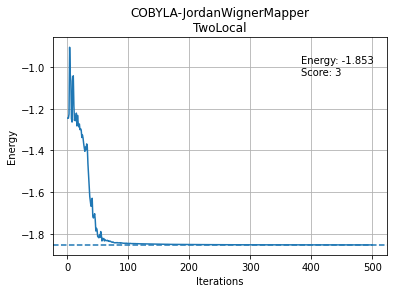

In [5]:
# Store results in a dictionary

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates

pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data

import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

We can see the energy evolution with the number of iterations of a given optimizer (`COBYLA`).
For this simple problem, `COBYLA` is sufficient to converge to the correct state.
Many other optimizers will do the job here.

Next, let's run the VQE again and answer the following questions.

<div class="alert alert-block alert-danger">
    
<b>Questions 2</b> 

Experiment with all the parameters and then:

1. Can you find your best (best score) heuristic ansatz (by modifying parameters of `TwoLocal` ansatz) and optimizer?
2. Can you find your best q-UCC ansatz (choose among `UCCSD, PUCCD or SUCCD` ansatzes) and optimizer?
3. In the cell where we define the ansatz, 
   can you modify the `Custom` ansatz by placing gates yourself to write a better circuit than your `TwoLocal` circuit? 

For each question, give `ansatz` objects.
Remember, you have to reach the chemical accuracy $|E_{exact} - E_{VQE}| \leq 0.004 $ Ha $= 4$ mHa.
    
</div>

</div>
    
<div class="alert alert-block alert-success">
    
**Answer to question 1:** find the best `TwoLocal` ansatz. To this end, it is necessary simply to start by using the minimal number of CNOTs but still connecting all the qubits (i.e. `linear` entanglement  with `repetitions` = 1). One can use all available single qubit rotations (as they do not influence the score) since, perhaps, no additional CNOTs are needed. Therefore, we enable rotations at the end of the circuit with `skip_final_rotation_layer = False`. And indeed, only a single layer of CNOTs was sufficient to reach the ground state.

    rotation_blocks = ['ry']
    entanglement_blocks = 'cx'
    entanglement = 'linear'
    repetitions = 1
    skip_final_rotation_layer = False
    
**Answer to question 2:** find the best `UCC` ansatz. To this end, it is also intelligent to start with the shortest possible Ansatz. The `UCCSD` ansatz includes the single excitations and therefore is already longer than `PUCCD` and `SUCCD` that do not include them. The `PUCCD` ansatz uses only pair electron double excitations. The `SUCCD` includes not only the pair but singlet type excitations also (see the tutorial) so in general `PUCCD` is shortest. In this case, `PUCCD` and `SUCCD` are the same (identical pair double excitation) and both produce sufficiently accurate results. 

    ansatz_type = "PUCCD" # or "SUCCD"
    
**Answer to question 3:** find the best `Custom` ansatz. In this case, it is identical to the best `TwoLocal` ansatz. 
    
</div>


# Solution for Part 2: Final Challenge - VQE for LiH molecule 


In this part, you will simulate LiH molecule using the STO-3G basis with the PySCF driver.
Let's now run the Hartree-Fock calculation.

In [6]:
from qiskit_nature.drivers import PySCFDriver

molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

Let's first check how many qubits we need for the simulation of this molecule.

In [7]:
n_el = qmolecule.num_alpha + qmolecule.num_beta
n_mo = qmolecule.num_molecular_orbitals
n_so = 2 * qmolecule.num_molecular_orbitals
n_q = n_so
e_nn = qmolecule.nuclear_repulsion_energy

print("Number of electrons: {}".format(n_el))
print("Number of molecular orbitals: {}".format(n_mo))
print("Number of spin-orbitals: {}".format(n_so))
print("Number of qubits: {}".format(n_q))
print("Nuclear repulsion energy: {}".format(e_nn))

Number of electrons: 4
Number of molecular orbitals: 6
Number of spin-orbitals: 12
Number of qubits: 12
Nuclear repulsion energy: 1.0259348796432726


As H atom has 1 electron being in 1s molecular orbitals and Li atom has 3 electrons in 1s, 2s and 2p (with $x,y,z$ components) molecular orbitals. This means that we have 1 + 5 = 6 molecular orbitals in total and therefore 12 spin-orbitals when we consider their spin up and spin down components.
So, as in Jordan-Wigner mapping we represent each spin-orbital as a qubit, we would need 12 qubits. 
We could in principle construct the Hamiltonian for this problem and compute the ground state.
But, one can find ways to reduce the dimensionality of the problem. 
In turn, this will reduce the ansatz space to explore, rendering a simpler solution (i.e. lower number of CNOTs).

In [8]:
# Generate the second-quantized operators 

from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
problem = ElectronicStructureProblem(driver)
second_q_ops = problem.second_q_ops() 
main_op = second_q_ops[0]

from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the qubit converter

mapper_type = 'JordanWignerMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)

# Exact solution

from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -8.908697116424248
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.908697116424
  - computed part:      -8.908697116424
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.882762236781
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.74455828]
    - computed part:      [0.0  0.0  4.74455828]
  > Dipole moment (a.u.): [0.0  0.0  -1.82039607]  Total: 1.82039607
                 (debye): [0.0  0.0  -4.62698485]  Total: 4.62698485
 


The energy we shall target is $ -8.9086$ Ha. 

We can now use the functionalities of Qiskit to reduce the number of qubits. 
As we know the energy that we should obtain from the original Hamiltonian, we can verify that, after massaging the Hamiltonian, we still get the correct energies.
As suggested, there are three possibilities that can be used simultaneously:

- freeze the core electrons that do not contribute significantly to chemistry and consider only the valence electrons. Qiskit  already has this functionality implemented. So inspect the different transformers in `qiskit_nature.transformers`  and find the one that performs the freeze core approximation.
- use `ParityMapper` with `two_qubit_reduction=True` to eliminate 2 qubits.
- reduce the number of qubits by inspecting the symmetries of your Hamiltonian. Find a way to use `Z2Symmetries` in Qiskit.

The elimination of 2 qubits results from the fact that the Hamiltonian commutes with the spin-up and spin-down number operators. For each symmetry (2 here), one can eliminate a qubit. This is part of the tapering procedure and details are given in [Bravyi *et al*, 2017](https://arxiv.org/abs/1701.08213v1).


In [9]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer

freezeCoreTransformer = FreezeCoreTransformer(True)

problem = ElectronicStructureProblem(driver, q_molecule_transformers=[freezeCoreTransformer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

mapper = ParityMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)

symmetries = True
if symmetries:
    num_particles = (problem.molecule_data_transformed.num_alpha,
                 problem.molecule_data_transformed.num_beta)
    converter = QubitConverter(mapper, two_qubit_reduction=True, z2symmetry_reduction="auto")
    qubit_op = converter.convert(
        main_op,
        num_particles,
        sector_locator=problem.symmetry_sector_locator,
        )
else:
    converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
    qubit_op = converter.convert(main_op, num_particles=num_particles)

print("Number of qubits: ", qubit_op.num_qubits)

Number of qubits:  6


Using the automatic symmetry-based reduction `z2symmetry_reduction="auto"` we can reduce an 8 qubit problem (parity mapping with two qubit reduction and frozen core approximation) to a 6 qubit problem. 

In [10]:
result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -1.0897823963487385
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.90847269193
  - computed part:      -1.089782396349
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.882537812287
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [None  None  4.74515931]
    - computed part:      [None  None  4.74910617]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [None  None  -1.8209971]  Total: 1.8209971
                 (debye): [None  None  -4.62851252]  Total: 4.62851252
 


The exact energy has not changed after the transformation of `qubit_op`.

However, here, a more intelligent solution is possible.
As pointed out by many of our participants, one can use some chemistry knowledge to eliminate molecular orbitals.
There is actually a paper by [K. Setia et al.](https://arxiv.org/pdf/1910.14644.pdf) showing that the knowledge of molecular symmetries allows to reduce the number of qubits further than what is possible by the default with tapering.

The LiH has a symmetry along z-axis. 
The Li 1s orbital has core electrons that can be frozen as they do not participate in bonding. 
In the ground state of this molecule the electrons from H 1s and Li 2s orbitals mostly interact with some mixing with 2$p_z$ due to the orientation of the molecule.
Therefore, we may try to eliminate the corresponding orbitals by using the `FreezeCoreTransformer`.

In [11]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer

# Eliminate the MOs 3 and 4 that correspond to 2px and 2py in addition to freezen the core electrons
freezeCoreTransformer = FreezeCoreTransformer(True,[3,4])

problem = ElectronicStructureProblem(driver, q_molecule_transformers=[freezeCoreTransformer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

mapper = ParityMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)

symmetries = False
if symmetries:
    num_particles = (problem.molecule_data_transformed.num_alpha,
                 problem.molecule_data_transformed.num_beta)
    converter = QubitConverter(mapper, two_qubit_reduction=True, z2symmetry_reduction="auto")
    qubit_op = converter.convert(
        main_op,
        num_particles,
        sector_locator=problem.symmetry_sector_locator,
        )
else:
    converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
    qubit_op = converter.convert(main_op, num_particles=num_particles)

print("Number of qubits: ", qubit_op.num_qubits)

Number of qubits:  4


In [12]:
result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)

Exact electronic energy -1.0887060157347392


One can check that when activating the tapering with `symmetries = True` we cannot further eliminate any qubits.
We see that by eliminating the orbitals 2$p_x$ and 2$p_y$, we obtain $-1.0887$ Ha instead of $-1.0897$ Ha. An error of 1 mHa and considering the required accuracy of 4 mHa in this challenge, it is acceptable. 

Create the Hartree-Fock state for this problem.

In [13]:
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
init_state.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────

Start with a simplest circuit that corresponds to `TwoLocal` with linear entanglement, a single layer of entanglers and final rotations (`ansatz 1`).

In [14]:
# ansatz 1

num_qubits = qubit_op.num_qubits
qc = QuantumCircuit(num_qubits)
param_count = 1
for i in range(num_qubits):
    theta = Parameter(f"ry_angle{param_count}" )
    qc.ry(theta, i)
    param_count += 1
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)
for i in range(num_qubits):
    theta = Parameter(f"ry_angle{param_count}")
    qc.ry(theta, i)
    param_count += 1
ansatz = qc
ansatz.compose(init_state, front=True, inplace=True)
ansatz.draw()

# ansatz 2

# num_qubits = qubit_op.num_qubits
# qc = QuantumCircuit(num_qubits)
# param_count = 1
# for i in range(num_qubits):
#     theta = Parameter(f"ry_angle{param_count}" )
#     theta2 = Parameter(f"rz_angle{param_count}" )
#     qc.ry(theta, i)
#     qc.rz(theta2, i)
#     param_count += 1
# qc.cx(2,3)
# qc.cx(0,2)
# qc.cx(1,3)
# for i in range(num_qubits):
#     theta = Parameter(f"ry_angle{param_count}")
#     theta2 = Parameter(f"rz_angle{param_count}" )
#     qc.ry(theta, i)
#     qc.rz(theta2, i)
#     param_count += 1
# ansatz = qc
# ansatz.compose(init_state, front=True, inplace=True)
# ansatz.draw()

┌───┐      ┌───────────────┐     ┌───────────────┐                 »
q_0: ──────┤ X ├──────┤ RY(ry_angle1) ├──■──┤ RY(ry_angle5) ├─────────────────»
           ├───┤      ├───────────────┤┌─┴─┐└───────────────┘┌───────────────┐»
q_1: ──────┤ X ├──────┤ RY(ry_angle2) ├┤ X ├────────■────────┤ RY(ry_angle6) ├»
     ┌─────┴───┴─────┐└───────────────┘└───┘      ┌─┴─┐      └───────────────┘»
q_2: ┤ RY(ry_angle3) ├────────────────────────────┤ X ├──────────────■────────»
     ├───────────────┤                            └───┘            ┌─┴─┐      »
q_3: ┤ RY(ry_angle4) ├─────────────────────────────────────────────┤ X ├──────»
     └───────────────┘                                             └───┘      »
«                      
«q_0: ─────────────────
«                      
«q_1: ─────────────────
«     ┌───────────────┐
«q_2: ┤ RY(ry_angle7) ├
«     ├───────────────┤
«q_3: ┤ RY(ry_angle8) ├
«     └───────────────┘

Run the VQE.

In [15]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

from qiskit.algorithms.optimizers import SLSQP
optimizer_type = 'SLSQP'
optimizer = SLSQP(maxiter=1000)

from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

OrderedDict([   ('aux_operator_eigenvalues', None),
                ('cost_function_evals', 382),
                (   'eigenstate',
                    array([ 1.44327503e-03+1.60578482e-19j, -4.96357873e-03+4.24245819e-21j,
        2.65619538e-02+4.52268009e-20j, -9.91390894e-01+1.19488495e-21j,
       -5.41568549e-02-6.62856308e-18j, -2.74447172e-04-1.75125592e-19j,
        9.17474940e-04+3.43313771e-20j, -2.41084820e-02+9.07029569e-22j,
       -2.75860781e-03-3.37616323e-19j, -6.16883823e-06-8.91977002e-21j,
        4.95846166e-06+1.67624745e-21j,  3.30762441e-04+4.42861933e-23j,
        1.13527910e-01+1.38945035e-17j,  3.22321956e-04+3.67090593e-19j,
       -5.70155761e-04-6.96197591e-20j,  4.80879778e-05-1.83934306e-21j])),
                ('eigenvalue', -1.0863669627133823),
                (   'optimal_parameters',
                    {   Parameter(ry_angle2): -0.0059800167426662665,
                        Parameter(ry_angle3): -3.1416857285055806,
                        Param

,optimizer,ansatz,# of qubits,error (mHa),pass,score
0,SLSQP,QuantumCircuit,4,2.339053,True,3


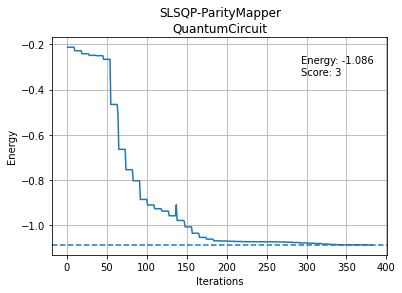

In [16]:
# Store results in a dictionary

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates

pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data

import pandas as pd
import os.path
filename = 'results_lih.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', 'error (mHa)', 'pass', 'score']]

For example, two solutions are possible here. Due to the simplification of the Hamiltonian, the solution is a simple `RY` ansatz with linear entanglement (`ansatz 1`). The `ansatz 1` has lower number of single qubit rotations than `ansatz 2` which simplifies the classical optimization. However, it is 0.35 mHa worse than `ansatz 2` in terms of accuracy.
The target energy is $-1.0897$ Ha and the one obtained with VQE is $-1.0863$ Ha which is withing 4 mHa required to pass.